In [1]:
from tqdm import tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("행정동_월별_배출량.csv",encoding = "cp949")

In [4]:
df

,emd_nm,y_m,em_g
0,외도동,2018-01,95864700
1,외도동,2018-02,88582050
2,외도동,2018-03,97356250
3,외도동,2018-04,88844750
4,외도동,2018-05,94064300
...,...,...,...
1671,한경면,2021-02,17276700
1672,한경면,2021-03,21007400
1673,한경면,2021-04,22908150
1674,한경면,2021-05,26927600


### 성능 확인용 데이터 셋 생성

In [5]:
train_df = df.loc[df["y_m"] < "2021-04"]

In [6]:
test_df = df.loc[df["y_m"] >= "2021-04"]

In [7]:
# 예측 데이터와 비교할 실제 4,5,6월 행정동별 데이터 셋 생성
temp = pd.DataFrame(data= test_df["emd_nm"].unique())
temp.rename(columns = {0 : "emd_nm"},inplace=True)

for i in test_df["y_m"].unique():
    temp = pd.merge(temp,df.loc[df["y_m"] == i,["emd_nm","em_g"]],how="right",on = "emd_nm")
    temp.rename(columns = {"em_g" : i},inplace=True)
    
temp.to_csv("행정동_월별_배출량_2021_04.csv",encoding = "cp949",index = False)    

In [8]:
temp

,emd_nm,2021-04,2021-05,2021-06
0,외도동,89457350,97421950,100096900
1,아라동,94682900,107045700,112190800
2,노형동,212851000,227061100,239069250
3,도두동,17377150,19663550,19733350
4,오라동,51424200,57321800,58187300
5,삼양동,84829840,93122870,96172500
6,이도2동,192527200,215882550,225423200
7,일도2동,131462200,147183350,147438200
8,건입동,35386850,38047500,36493300
9,화북동,99636900,109316800,110750050


### 날짜 지정 범위 생성과 시리즈 객체 변환

In [9]:
# 데이터프레임을 Series로 변환하는 함수
def time_series(df, i):
    # 행정동별로 데이터를 뽑습니다.
    location = df[df['emd_nm']==i]
    ## 날짜 지정 범위는 시작 월부터 2021년 5월 전까지 기준
    index = pd.date_range(min(location['y_m']),'2021-04',freq='BM') 
    ## 시리즈 객체로 변환
    ts = pd.Series(location['em_g'].values,index=index)
    return ts

### 매출 변동 계수
매출 변동 계수가 높은 행정동을 로그 정규화 시 예측 성능이 저하된다.
따라서 변동 계수가 0.3 이하의 데이터 값만 로그 정규화하여 사용

In [10]:
# 매출 변동 계수를 구하는 함수
def coefficient_variation(df, i):
    cv_data = df.groupby(['emd_nm']).em_g.std()/df.groupby(['emd_nm']).em_g.mean()
    cv = cv_data[i]
    return cv

## 탐색적 데이터 분석
### 행정동별 매출 특성
#### 계절성이 있는 행정동

adf - test는 통계학에서 실행하는 가설 검정의 절차를 따른다.
- 귀무가설:시계열 자료가 정상 시계열이 아니다.
- 대립 가설: 시계열 자료가 정상성을 만족한다.

pmdarima 패키지에 있는 ADFTest클래스 import

p-value 0.05보다 낮으면 대립가설이 채택 -> 정상시계열이다. -> 차분이 필요하지 않다.

0.05보다 높으면 귀무가설이 채택 -> 정상시계열이 아니다 -> 차분이 필요하다.

In [11]:
new_df = train_df

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 267.67it/s]


<AxesSubplot:>

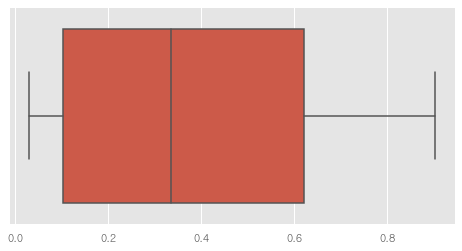

In [12]:
from pmdarima.arima import ADFTest
## ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    return ADFTest().should_diff(y)[0]

adf_p = []
count = 0
skipped = []

for i in tqdm(new_df['emd_nm'].unique()):
    ts = time_series(new_df,i)
    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    except:
        skipped.append(i)

plt.figure(figsize=(8, 4))
sns.boxplot(adf_p)

In [13]:
# p-value가 0.05보다 작은 행정동의 개수
print(count)

5


In [14]:
# ADF-Test 오류 행정동 개수
if skipped:
    print(f"WarningCount: {len(skipped)}, emd_nm_list:{skipped}")

42개의 행정동중 5개를 제외한 37개의 행정동이 정상시계열이 아니다.

## 모델 구축과 검증
### 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

In [15]:
#!pip install tzlocal

In [16]:
# import rpy2
# from rpy2.robjects.packages import importr # rpy2 내의 패키지를 불러올 importr 클래스

# utils = importr('utils') # utils 패키지를 임포트
# utils.install_packages('forecast') # r의 forecast 패키지 설치.
# utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치

### 시계열 모델 선택과 검증
#### 1. 로그 정규화를 활용한 자기회귀누적이동평균 모델 (ARIMA)

In [17]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('em_g') # em_g 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)# str 형식으로 정의된 auto_arima
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

loc_name = []
final_pred1 = []
final_pred2 = []
final_pred3 = []

for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    
    cv = coefficient_variation(new_df, i)
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(location['em_g']), start=c(start_year,start_month), frequency=12) 
        # 자동회귀누적이동평균 model
        forecast_log = auto_arima(train_log)
        # 3개월 예상을 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(exp(forecast_log)).values[0])
        final_pred2.append(pandas2ri.ri2py(exp(forecast_log)).values[1])
        final_pred3.append(pandas2ri.ri2py(exp(forecast_log)).values[2])
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        train = ts(location['em_g'], start=c(start_year,start_month), frequency=12)
        # 자동회귀누적이동평균 model
        forecast = auto_arima(train)
        # 3개월 예상을 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(forecast).values[0])
        final_pred2.append(pandas2ri.ri2py(forecast).values[1])
        final_pred3.append(pandas2ri.ri2py(forecast).values[2])
    

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:16<00:00,  2.51it/s]


In [18]:
#4월 예측값
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
외도동,8.521465e+07
아라동,1.009653e+08
노형동,2.206920e+08
도두동,1.595574e+07
오라동,5.129338e+07
삼양동,8.195378e+07
이도2동,1.806331e+08
일도2동,1.133451e+08
건입동,3.004019e+07
화북동,9.639422e+07


In [19]:
#5월 예측값
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
외도동,9.203226e+07
아라동,1.099582e+08
노형동,2.321361e+08
도두동,1.751420e+07
오라동,5.782368e+07
삼양동,9.212511e+07
이도2동,1.940203e+08
일도2동,1.265082e+08
건입동,3.354205e+07
화북동,1.117255e+08


In [20]:
#6월 예측값
data_df3 = pd.DataFrame(data = final_pred3,index = loc_name)
data_df3

,0
외도동,9.038860e+07
아라동,1.054580e+08
노형동,2.275352e+08
도두동,1.805928e+07
오라동,5.971091e+07
삼양동,9.280420e+07
이도2동,1.984931e+08
일도2동,1.170644e+08
건입동,3.300128e+07
화북동,1.130056e+08


In [21]:
# 로그 정규화와 ARIMA를 활용한 4,5,6월 음식물 쓰레기 배출량 예측 데이터셋 생성 
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-04","0_y" : "2021-05"},inplace=True)
final = pd.merge(final,data_df3,how = "left",on = final.행정동명)
final = final.drop("key_0",axis = 1)
final.rename(columns = {0:"2021-06"},inplace=True)
final

,행정동명,2021-04,2021-05,2021-06
0,외도동,8.521465e+07,9.203226e+07,9.038860e+07
1,아라동,1.009653e+08,1.099582e+08,1.054580e+08
2,노형동,2.206920e+08,2.321361e+08,2.275352e+08
3,도두동,1.595574e+07,1.751420e+07,1.805928e+07
4,오라동,5.129338e+07,5.782368e+07,5.971091e+07
5,삼양동,8.195378e+07,9.212511e+07,9.280420e+07
6,이도2동,1.806331e+08,1.940203e+08,1.984931e+08
7,일도2동,1.133451e+08,1.265082e+08,1.170644e+08
8,건입동,3.004019e+07,3.354205e+07,3.300128e+07
9,화북동,9.639422e+07,1.117255e+08,1.130056e+08


In [22]:
final.to_csv("final_1_2021456_log.csv",encoding = "cp949",index=False)

#### 2. 로그 정규화를 활용한 지수평활법

In [23]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('em_g') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets 
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

loc_name = []
final_pred1 = []
final_pred2 = []
final_pred3 = []


   
    
    
for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    
    cv = coefficient_variation(new_df, i)
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(location['em_g']), start=c(start_year,start_month), frequency=12) 
        # 지수평활법 model
        forecast_log = ets(train_log)
        # 3개월 예상 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(exp(forecast_log)).values[0])
        final_pred2.append(pandas2ri.ri2py(exp(forecast_log)).values[1])
        final_pred3.append(pandas2ri.ri2py(exp(forecast_log)).values[2])
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        train = ts(location['em_g'], start=c(start_year,start_month), frequency=12)
        # 지수평활법 model
        forecast = ets(train)
        # 3개월 예상 final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(forecast).values[0])
        final_pred2.append(pandas2ri.ri2py(forecast).values[1])
        final_pred3.append(pandas2ri.ri2py(forecast).values[2])

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:21<00:00,  1.99it/s]


In [24]:
# 4월 예측 값
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
외도동,8.501466e+07
아라동,1.029273e+08
노형동,2.251547e+08
도두동,1.577918e+07
오라동,5.138660e+07
삼양동,7.937013e+07
이도2동,1.815603e+08
일도2동,1.226726e+08
건입동,3.091494e+07
화북동,9.063519e+07


In [25]:
# 5월 예측 값
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
외도동,9.193565e+07
아라동,1.123047e+08
노형동,2.409491e+08
도두동,1.717008e+07
오라동,5.539640e+07
삼양동,8.618875e+07
이도2동,1.931302e+08
일도2동,1.306390e+08
건입동,3.384690e+07
화북동,9.789419e+07


In [26]:
# 6월 예측 값
data_df3 = pd.DataFrame(data = final_pred3,index = loc_name)
data_df3

,0
외도동,9.195303e+07
아라동,1.107814e+08
노형동,2.392159e+08
도두동,1.767209e+07
오라동,5.743902e+07
삼양동,8.673530e+07
이도2동,2.014272e+08
일도2동,1.330479e+08
건입동,3.499105e+07
화북동,1.022016e+08


In [27]:
# 로그 정규화를 활용한 지수평활법을 이용한 4,5,6월 예측 데이터 프레임 생성
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-04","0_y" : "2021-05"},inplace=True)
final = pd.merge(final,data_df3,how = "left",on = final.행정동명)
final = final.drop("key_0",axis = 1)
final.rename(columns = {0:"2021-06"},inplace=True)
final

,행정동명,2021-04,2021-05,2021-06
0,외도동,8.501466e+07,9.193565e+07,9.195303e+07
1,아라동,1.029273e+08,1.123047e+08,1.107814e+08
2,노형동,2.251547e+08,2.409491e+08,2.392159e+08
3,도두동,1.577918e+07,1.717008e+07,1.767209e+07
4,오라동,5.138660e+07,5.539640e+07,5.743902e+07
5,삼양동,7.937013e+07,8.618875e+07,8.673530e+07
6,이도2동,1.815603e+08,1.931302e+08,2.014272e+08
7,일도2동,1.226726e+08,1.306390e+08,1.330479e+08
8,건입동,3.091494e+07,3.384690e+07,3.499105e+07
9,화북동,9.063519e+07,9.789419e+07,1.022016e+08


In [28]:
final.to_csv("final_2_2021456_log.csv",encoding = "cp949",index=False)

#### 3. log 정규화와 앙상블을 적용

In [29]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# pandas2ri를 활성화 
pandas2ri.activate()

hybridModel = """
    function(ts){
        library(forecast)
        library(forecastHybrid)
        d_params=ndiffs(ts)
        hb_mdl<-hybridModel(ts, models="aes", # auto_arima, ets, stlm 앙상블 모델
                        a.arg=list(max.p=2, d=d_params), # auto_arima parameter
                        weight="equal") # 가중치를 동일하게 줌(평균)
        forecasted_data<-forecast(hb_mdl, h=3) # 이후 3개월(h=3)을 예측
        outdf<-data.frame(forecasted_data$mean)
        colnames(outdf)<-c('em_g')
        outdf
    }
""" 
# r() 함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

loc_name = []
final_pred1 = []
final_pred2 = []
final_pred3 = []

for i in tqdm(new_df.emd_nm.unique()):
    location = new_df[new_df['emd_nm']==i]
    start_year = int(min(location['y_m'])[:4]) ## 시작 년도
    start_month = int(min(location['y_m'])[5:]) ##시작 월
    cv = coefficient_variation(new_df, i)
    # 배출량 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(location['em_g']), start=c(start_year,start_month), frequency=12) 
        # 앙상블 예측
        forecast_log = hybridModel(train_log)
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(exp(forecast_log)).values[0])
        final_pred2.append(pandas2ri.ri2py(exp(forecast_log)).values[1])
        final_pred3.append(pandas2ri.ri2py(exp(forecast_log)).values[2])
    # 배출량 변동 계수가 0.3 이상인 경우
    else:
        train = ts(location['em_g'], start=c(start_year,start_month), frequency=12)
        # 앙상블 예측
        forecast = hybridModel(train)
        # 2개월 예상, final_pred에 추가
        loc_name.append(i)
        final_pred1.append(pandas2ri.ri2py(forecast).values[0])
        final_pred2.append(pandas2ri.ri2py(forecast).values[1])
        final_pred3.append(pandas2ri.ri2py(forecast).values[2])


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:37<00:00,  1.12it/s]


In [30]:
# 4월 예측 데이터
data_df1 = pd.DataFrame(data = final_pred1,index = loc_name)
data_df1

,0
외도동,8.515780e+07
아라동,1.021441e+08
노형동,2.218795e+08
도두동,1.585325e+07
오라동,5.129102e+07
삼양동,8.016560e+07
이도2동,1.816033e+08
일도2동,1.193462e+08
건입동,3.033846e+07
화북동,9.237893e+07


In [31]:
# 5월 예측 데이터
data_df2 = pd.DataFrame(data = final_pred2,index = loc_name)
data_df2

,0
외도동,9.190845e+07
아라동,1.115928e+08
노형동,2.356498e+08
도두동,1.732207e+07
오라동,5.612796e+07
삼양동,8.812413e+07
이도2동,1.945500e+08
일도2동,1.291037e+08
건입동,3.326206e+07
화북동,1.022880e+08


In [32]:
# 6월 예측 데이터
data_df3 = pd.DataFrame(data = final_pred3,index = loc_name)
data_df3

,0
외도동,9.140673e+07
아라동,1.089593e+08
노형동,2.330763e+08
도두동,1.783283e+07
오라동,5.809045e+07
삼양동,8.856791e+07
이도2동,2.008986e+08
일도2동,1.274305e+08
건입동,3.363159e+07
화북동,1.055273e+08


In [33]:
# 로그 정규화와 앙상블 모델을 활용한 4,5,6월 음식물 쓰레기 배출량 예측 데이터셋 생성 
final = pd.merge(data_df1,data_df2,how = "left",on = data_df1.index)
final.rename( columns = {"key_0" : "행정동명","0_x" : "2021-04","0_y" : "2021-05"},inplace=True)
final = pd.merge(final,data_df3,how = "left",on = final.행정동명)
final = final.drop("key_0",axis = 1)
final.rename(columns = {0:"2021-06"},inplace=True)
final

,행정동명,2021-04,2021-05,2021-06
0,외도동,8.515780e+07,9.190845e+07,9.140673e+07
1,아라동,1.021441e+08,1.115928e+08,1.089593e+08
2,노형동,2.218795e+08,2.356498e+08,2.330763e+08
3,도두동,1.585325e+07,1.732207e+07,1.783283e+07
4,오라동,5.129102e+07,5.612796e+07,5.809045e+07
5,삼양동,8.016560e+07,8.812413e+07,8.856791e+07
6,이도2동,1.816033e+08,1.945500e+08,2.008986e+08
7,일도2동,1.193462e+08,1.291037e+08,1.274305e+08
8,건입동,3.033846e+07,3.326206e+07,3.363159e+07
9,화북동,9.237893e+07,1.022880e+08,1.055273e+08


In [34]:
final.to_csv("final_3_2021456_hybrid.csv",encoding = "cp949",index=False)

## 성능 비교

In [35]:
# 실제값 데이터셋
df = pd.read_csv("행정동_월별_배출량_2021_04.csv",encoding = "cp949")
# 예측값 데이터셋
df1 = pd.read_csv("final_1_2021456_log.csv",encoding = "cp949")
df2 = pd.read_csv("final_2_2021456_log.csv",encoding = "cp949")
df3 = pd.read_csv("final_3_2021456_hybrid.csv",encoding = "cp949")

In [36]:
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
import numpy as np

In [37]:
# 성능 비교를 위한 지표를 측정하기 위한 함수 생성
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [38]:
print("Arima 로그 정규화 결과")
print()
print("4월")
regression_results(df["2021-04"], df1["2021-04"])
print()
print("5월")
regression_results(df["2021-05"], df1["2021-05"])
print()
print("6월")
regression_results(df["2021-06"], df1["2021-06"])

Arima 로그 정규화 결과

4월
explained_variance:  0.989
mean_squared_log_error:  0.0096
r2:  0.9883
MAE:  3657922.9457
MSE:  25453973208486.6
RMSE:  5045193.0794

5월
explained_variance:  0.9846
mean_squared_log_error:  0.0143
r2:  0.9835
MAE:  4651341.7613
MSE:  43754208039853.53
RMSE:  6614696.3679

6월
explained_variance:  0.9697
mean_squared_log_error:  0.0387
r2:  0.9653
MAE:  7224156.5529
MSE:  100702840584291.88
RMSE:  10035080.4972


In [39]:
print("지수평활법 로그 정규화 결과")
print()
print("4월")
regression_results(df["2021-04"], df2["2021-04"])
print()
print("5월")
regression_results(df["2021-05"], df2["2021-05"])
print()
print("6월")
regression_results(df["2021-06"], df2["2021-06"])

지수평활법 로그 정규화 결과

4월
explained_variance:  0.9888
mean_squared_log_error:  0.0074
r2:  0.9887
MAE:  3926209.767
MSE:  24605631891184.332
RMSE:  4960406.424

5월
explained_variance:  0.9818
mean_squared_log_error:  0.0176
r2:  0.9806
MAE:  5512203.1727
MSE:  51682010670961.445
RMSE:  7189020.1468

6월
explained_variance:  0.9765
mean_squared_log_error:  0.0368
r2:  0.9742
MAE:  6270137.4463
MSE:  74728808193250.97
RMSE:  8644582.5922


In [40]:
print("앙상블 + 로그 정규화 결과")
print()
print("4월")
regression_results(df["2021-04"], df3["2021-04"])
print()
print("5월")
regression_results(df["2021-05"], df3["2021-05"])
print()
print("6월")
regression_results(df["2021-06"], df3["2021-06"])

앙상블 + 로그 정규화 결과

4월
explained_variance:  0.9921
mean_squared_log_error:  0.0079
r2:  0.9908
MAE:  3476109.3329
MSE:  19969758170493.89
RMSE:  4468753.5366

5월
explained_variance:  0.9815
mean_squared_log_error:  0.0182
r2:  0.9808
MAE:  5582513.0723
MSE:  51164838269992.71
RMSE:  7152960.1054

6월
explained_variance:  0.9705
mean_squared_log_error:  0.0384
r2:  0.9686
MAE:  6962310.0843
MSE:  91125183272549.4
RMSE:  9545951.1455
